In [ ]:
!pip install yfinance

     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 6.4 MB 10.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [ ]:
# Set up the parameters
N_PORTFOLIOS = 10 ** 7
N_DAYS = 252
RISKY_ASSETS = ['TSLA', 'NIO', 'LCID', 'XPEV', 'LI', 'ARVL', 'FSR']
RISKY_ASSETS.sort()
START_DATE = '2020-03-11'
END_DATE = '2022-02-28'
n_assets = len(RISKY_ASSETS)

In [ ]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE,
end=END_DATE, adjusted=True)

[*********************100%***********************]  7 of 7 completed


In [ ]:
prices_df["Adj Close"].describe()

,ARVL,FSR,LCID,LI,NIO,TSLA,XPEV
count,496.000000,496.000000,363.000000,398.000000,496.000000,496.000000,378.000000
mean,14.030923,14.556734,24.448890,26.905503,31.005746,604.284184,38.248227
std,6.800582,3.375437,11.347623,5.951397,16.296480,287.351444,9.841454
min,3.060000,8.960000,9.630000,14.600000,2.370000,72.244003,17.450001
25%,9.777500,11.962500,18.405001,22.355000,18.262500,405.681992,33.075000
50%,10.740000,14.375000,23.580000,28.645000,35.650000,653.179993,39.414999
75%,17.827499,16.585000,28.010000,31.112501,42.834999,791.504990,45.004999
max,36.230000,28.500000,58.049999,43.959999,62.840000,1229.910034,72.169998


In [ ]:
# Calculate annualized average returns and the corresponding standard deviation
returns_df = prices_df['Adj Close'].pct_change().dropna()
avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

In [ ]:
# Simulate random portfolio weights
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
weights /= np.sum(weights, axis=1)[:, np.newaxis]

In [ ]:
# Calculate the portfolio metrics:
portf_rtns = np.dot(weights, avg_returns)
portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T,
                                    np.dot(cov_mat, weights[i]))))
portf_vol = np.array(portf_vol)
portf_sharpe_ratio = portf_rtns / portf_vol

In [ ]:
# Create a DataFrame containing all the data:
portf_results_df = pd.DataFrame({'returns': portf_rtns,
'volatility': portf_vol,
'sharpe_ratio':
portf_sharpe_ratio})

In [ ]:
# Locate the points creating the Efficient Frontier
N_POINTS = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(),
                            portf_results_df.returns.max(),
                            N_POINTS)
portf_rtns_ef = np.round(portf_rtns_ef, 2)
portf_rtns = np.round(portf_rtns, 2)
for point_index in range(N_POINTS):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns ==
                           portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))

portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


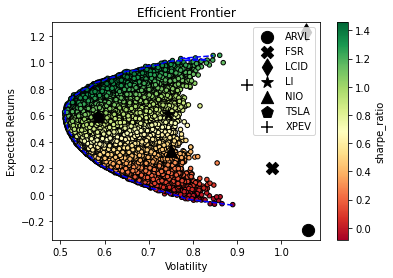

In [ ]:
# Plot the Efficient Frontier
MARKS = ['o', 'X', 'd', '*', '^','p', '+']

fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility',
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatility',
       ylabel='Expected Returns',
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]),
               y=avg_returns[asset_index],
               marker=MARKS[asset_index],
               s=150,
               color='black',
               label=RISKY_ASSETS[asset_index])
ax.legend()

In [ ]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]
min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

In [ ]:
print('Maximum Sharpe ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS,
weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe ratio portfolio ----
Performance
returns: 83.71% volatility: 57.48% sharpe_ratio: 145.63% 
Weights
ARVL: 0.16% FSR: 0.71% LCID: 32.47% LI: 9.54% NIO: 0.56% TSLA: 38.50% XPEV: 18.07% 

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


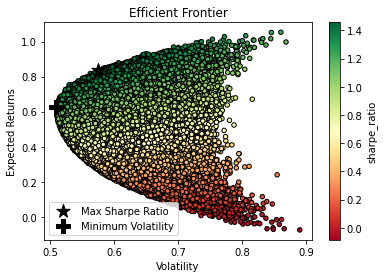

In [ ]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility',
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black',
                      ax=ax)
ax.scatter(x=max_sharpe_portf.volatility,
           y=max_sharpe_portf.returns,
           c='black', marker='*',
           s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility,
           y=min_vol_portf.returns,
           c='black', marker='P',
           s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns',
       title='Efficient Frontier')
ax.legend()

In [ ]:
import numpy as np
import scipy.optimize as sco

In [ ]:
def get_portf_rtn(w, avg_rtns):
  return np.sum(avg_rtns * w)
def get_portf_vol(w, avg_rtns, cov_mat):
  return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

In [ ]:
def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):
  efficient_portfolios = []
  n_assets = len(avg_returns)
  args = (avg_returns, cov_mat)
  bounds = tuple((0,1) for asset in range(n_assets))
  initial_guess = n_assets * [1. / n_assets, ]
  for ret in rtns_range:
    constraints = ({'type': 'eq',
                    'fun': lambda x: get_portf_rtn(x, avg_rtns)
                    - ret},
                   {'type': 'eq',
                    'fun': lambda x: np.sum(x) - 1})
    efficient_portfolio = sco.minimize(get_portf_vol,
                                       initial_guess,
                                       args=args,
                                       method='SLSQP',
                                       constraints=constraints,
                                       bounds=bounds)
    efficient_portfolios.append(efficient_portfolio)
    return efficient_portfolios

In [ ]:
rtns_range = np.linspace(-0.22, 0.32, 200)

In [ ]:
efficient_portfolios = get_efficient_frontier(avg_returns,
                                              cov_mat,
                                              rtns_range)

In [ ]:
vols_range = [x['fun'] for x in efficient_portfolios]

NameError: ignored

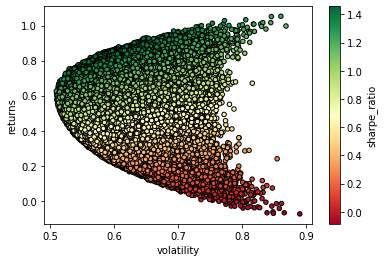

In [ ]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility',
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black',
                      ax=ax)
ax.plot(vols_range, rtns_range, 'b--', linewidth=3)
ax.set(xlabel='Volatility',
       ylabel='Expected Returns',
       title='Efficient Frontier')